In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


# Quick baselining
If you want to have a look at my visual EDA, where I describe the steps I will be taking after setting the baseline have a look at: https://www.kaggle.com/code/anopsy/visual-eda-steel-plate-defect-pred 

In [2]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = SettingWithCopyWarning)

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')

# 1. Specifing target columns, our classes

In [4]:
target_col = ['Pastry', 'Z_Scratch','K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# 2. Changing the one-hot-encoded classes into labels

In [6]:
train['label'] = np.argmax(train[target_col], axis=-1)

In [7]:
train['label'].value_counts()

label
6    6540
5    4761
2    3431
0    2284
1    1150
3     568
4     485
Name: count, dtype: int64

In [8]:
le = LabelEncoder()
X = train.drop(columns=['id','label','Pastry', 'Z_Scratch','K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
y = le.fit_transform(train['label'])

In [9]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state = 2137)

# 3. RandmizedSearchCV to find the optimal params

In [10]:
params_xgb = {
              'subsample': [0.8], 
              'objective': ['multi:softmax'], 
              'n_estimators': [200], 
              'min_child_weight': [5], 
              'max_depth': [5], 
              'learning_rate': [0.05], 
              'gamma': [1], 
              'colsample_bytree': [0.8]
}

params_lgb = {
               'objective': ['multiclassova'], 
               'num_leaves': [500], 
               'num_iterations': [100], 
               'min_data_in_leaf': [60], 
               'metric': ['multiclassova'], 
               'max_depth': [10], 
               'feature_fraction': [0.5], 
               'bagging_freq': [3], 
               'bagging_fraction': [0.8]
}

params_cat = {
        'min_data_in_leaf': [150], 
        'learning_rate': [0.1], 
        'iterations': [200], 
        'depth': [5]  
}

params_ada = {
        'learning_rate' : [0.01],
        'n_estimators' : [1500]
}

params_lr = {
        'tol': [5e-05], 
        'solver': ['liblinear'], 
        'penalty': ['l1'], 
        'max_iter': [100], 
        'fit_intercept':[ True], 
        'C': [1]  
}

In [11]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 2137)

In [12]:
tune_xgb = xgb.XGBClassifier(enable_categorical=True)
rand_xgb = RandomizedSearchCV(tune_xgb, param_distributions=params_xgb, n_iter=60, scoring='accuracy', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=0, random_state=2137)
rand_xgb.fit(X_train, y_train)
rand_xgb_pred = rand_xgb.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=60. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [13]:
print(roc_auc_score(y_test, rand_xgb_pred, multi_class='ovo'))
print(confusion_matrix(y_test, rand_xgb.predict(X_test)))
print(rand_xgb.best_params_)

0.8890488548011374
[[ 96  17   8   4   8  93 231]
 [  2 155   1   0   0  19  53]
 [  1   0 616   0   0   6  63]
 [  0   0   0  95   0   5  14]
 [ 10   2   0   0  20   8  57]
 [ 35  23   4   1   4 493 392]
 [ 72  65  60  28   6 323 754]]
{'subsample': 0.8, 'objective': 'multi:softmax', 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}


In [14]:
best_xgb = rand_xgb.best_estimator_
best_features = best_xgb.feature_importances_
for idx, feat in enumerate(X.columns):
    print(feat, best_features[idx])

X_Minimum 0.016246216
X_Maximum 0.019388884
Y_Minimum 0.010076192
Y_Maximum 0.010191427
Pixels_Areas 0.065137796
X_Perimeter 0.132093
Y_Perimeter 0.031080011
Sum_of_Luminosity 0.014120491
Minimum_of_Luminosity 0.018608136
Maximum_of_Luminosity 0.013043146
Length_of_Conveyer 0.036679264
TypeOfSteel_A300 0.05815988
TypeOfSteel_A400 0.046159748
Steel_Plate_Thickness 0.043344457
Edges_Index 0.013806502
Empty_Index 0.012136537
Square_Index 0.017578451
Outside_X_Index 0.08446831
Edges_X_Index 0.011902222
Edges_Y_Index 0.018494098
Outside_Global_Index 0.04349922
LogOfAreas 0.077803805
Log_X_Index 0.12256004
Log_Y_Index 0.018232992
Orientation_Index 0.035559542
Luminosity_Index 0.014308239
SigmoidOfAreas 0.0153214615


In [15]:
tune_lgb = lgb.LGBMClassifier()
rand_lgb = RandomizedSearchCV(tune_lgb, param_distributions=params_lgb, n_iter=40, scoring='accuracy', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=-1, random_state = 2137 )
rand_lgb.fit(X_train, y_train)
rand_lgb_pred = rand_lgb.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=40. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 1218, number of nega

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 1218, number of nega

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 1827, number of nega

In [16]:
#print(roc_auc_score(y_test, rand_lgb_pred, multi_class='ovo'))
print(confusion_matrix(y_test, rand_lgb.predict(X_test)))
print(rand_lgb.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[[ 95  15   7   4   5 100 231]
 [  4 137   1   0   0  22  66]
 [  1   0 620   0   0  12  53]
 [  0   0   0  94   0   3  17]
 [ 12   1   0   0  19  14  51]
 [ 38  20   6   1   3 478 406]
 [ 79  51  58  27  10 338 745]]
{'objective': 'multiclassova', 'num_leaves': 500, 'num_iterations': 100, 'min_data_in_leaf': 60, 'metric': 'multiclassova', 'max_depth': 10, 'feature_fraction': 0.5, 'bagging_freq': 3, 'bagging_fraction': 0.8}


In [17]:
best_lgb = rand_lgb.best_estimator_
best_features = best_lgb.feature_importances_
for idx, feat in enumerate(X.columns):
    print(feat, best_features[idx])

X_Minimum 2462
X_Maximum 2482
Y_Minimum 2623
Y_Maximum 2292
Pixels_Areas 2239
X_Perimeter 2018
Y_Perimeter 1867
Sum_of_Luminosity 2272
Minimum_of_Luminosity 2568
Maximum_of_Luminosity 1553
Length_of_Conveyer 1992
TypeOfSteel_A300 444
TypeOfSteel_A400 240
Steel_Plate_Thickness 1622
Edges_Index 2917
Empty_Index 2870
Square_Index 2477
Outside_X_Index 1991
Edges_X_Index 2222
Edges_Y_Index 1611
Outside_Global_Index 156
LogOfAreas 1830
Log_X_Index 1440
Log_Y_Index 1981
Orientation_Index 2254
Luminosity_Index 2962
SigmoidOfAreas 1888


In [18]:
tune_cat = cb.CatBoostClassifier()
rand_cat = RandomizedSearchCV(tune_cat, param_distributions=params_cat, n_iter=40, scoring='accuracy', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=False, random_state = 2137 )
rand_cat.fit(X_train, y_train)
rand_cat_pred = rand_cat.predict_proba(X_test)

0:	learn: 1.7833357	total: 84.9ms	remaining: 16.9s


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=40. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


1:	learn: 1.6801115	total: 102ms	remaining: 10.1s
2:	learn: 1.5886415	total: 127ms	remaining: 8.34s
3:	learn: 1.5233252	total: 144ms	remaining: 7.05s
4:	learn: 1.4649884	total: 167ms	remaining: 6.5s
5:	learn: 1.4154986	total: 185ms	remaining: 5.99s
6:	learn: 1.3772373	total: 202ms	remaining: 5.56s
7:	learn: 1.3449317	total: 219ms	remaining: 5.25s
8:	learn: 1.3141906	total: 238ms	remaining: 5.04s
9:	learn: 1.2891404	total: 256ms	remaining: 4.87s
10:	learn: 1.2649212	total: 276ms	remaining: 4.74s
11:	learn: 1.2468210	total: 297ms	remaining: 4.65s
12:	learn: 1.2261398	total: 319ms	remaining: 4.59s
13:	learn: 1.2090866	total: 335ms	remaining: 4.46s
14:	learn: 1.1900742	total: 354ms	remaining: 4.36s
15:	learn: 1.1792669	total: 371ms	remaining: 4.26s
16:	learn: 1.1636123	total: 387ms	remaining: 4.17s
17:	learn: 1.1528031	total: 404ms	remaining: 4.09s
18:	learn: 1.1424253	total: 424ms	remaining: 4.04s
19:	learn: 1.1345360	total: 443ms	remaining: 3.99s
20:	learn: 1.1250076	total: 463ms	remaini

In [19]:
#print(roc_auc_score(y_test, rand_cat_pred, multiclass = 'ovo'))
print(confusion_matrix(y_test, rand_cat.predict(X_test)))
print(rand_cat.best_params_)

[[ 78  14   6   3   6  95 255]
 [  0 139   0   0   0  18  73]
 [  1   0 609   0   0   7  69]
 [  0   0   0  92   0   2  20]
 [  7   3   0   0  16   6  65]
 [ 24  22   4   2   4 484 412]
 [ 55  63  58  28   8 295 801]]
{'min_data_in_leaf': 150, 'learning_rate': 0.1, 'iterations': 200, 'depth': 5}


In [20]:
best_cat = rand_cat.best_estimator_
best_features = best_cat.feature_importances_
for idx, feat in enumerate(X.columns):
    print(feat, best_features[idx])

X_Minimum 2.754903616454524
X_Maximum 3.0012825516568435
Y_Minimum 1.6200887076140065
Y_Maximum 1.0415589670068257
Pixels_Areas 2.7479659462265826
X_Perimeter 3.2072000270305914
Y_Perimeter 1.5441122223064336
Sum_of_Luminosity 2.4730356773489723
Minimum_of_Luminosity 4.225241796594084
Maximum_of_Luminosity 1.7929040896587132
Length_of_Conveyer 12.060959215254092
TypeOfSteel_A300 4.439609037291488
TypeOfSteel_A400 3.5647038949495173
Steel_Plate_Thickness 14.725771770620703
Edges_Index 3.7501671831114796
Empty_Index 2.479490203844251
Square_Index 2.44340384939448
Outside_X_Index 2.4990688157910834
Edges_X_Index 1.7634770888202755
Edges_Y_Index 2.505799120671042
Outside_Global_Index 1.025935483262583
LogOfAreas 3.5710800146640937
Log_X_Index 8.589534616277332
Log_Y_Index 1.620836321172064
Orientation_Index 4.6313569952178995
Luminosity_Index 3.1890239441852533
SigmoidOfAreas 2.731488843574786


In [21]:
tune_ada = AdaBoostClassifier()
rand_ada = RandomizedSearchCV(tune_ada, param_distributions=params_ada, n_iter=40, scoring='accuracy', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=0, random_state = 2137 )
rand_ada.fit(X_train, y_train)
rand_ada_pred = rand_cat.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=40. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [22]:
#print(roc_auc_score(y_test, rand_ada_pred, multiclass = 'ovo'))
print(confusion_matrix(y_test,rand_ada.predict(X_test)))
print(rand_ada.best_params_)

[[   0    1    4    3    0   39  410]
 [   0   10    0    0    0    6  214]
 [   0    0  588    0    0    0   98]
 [   0    0    0   84    0    1   29]
 [   0    0    0    2    0    0   95]
 [   0    2    3    2    0  205  740]
 [   0    2   56   20    0  106 1124]]
{'n_estimators': 1500, 'learning_rate': 0.01}


In [23]:
best_ada = rand_ada.best_estimator_
best_features = best_ada.feature_importances_
for idx, feat in enumerate(X.columns):
    print(feat, best_features[idx])

X_Minimum 0.015333333333333332
X_Maximum 0.018666666666666668
Y_Minimum 0.0
Y_Maximum 0.0
Pixels_Areas 0.054
X_Perimeter 0.02
Y_Perimeter 0.021333333333333333
Sum_of_Luminosity 0.012
Minimum_of_Luminosity 0.0
Maximum_of_Luminosity 0.13466666666666666
Length_of_Conveyer 0.07333333333333333
TypeOfSteel_A300 0.034666666666666665
TypeOfSteel_A400 0.0
Steel_Plate_Thickness 0.2673333333333333
Edges_Index 0.03933333333333333
Empty_Index 0.018666666666666668
Square_Index 0.0
Outside_X_Index 0.021333333333333333
Edges_X_Index 0.0
Edges_Y_Index 0.0
Outside_Global_Index 0.0033333333333333335
LogOfAreas 0.052
Log_X_Index 0.005333333333333333
Log_Y_Index 0.05733333333333333
Orientation_Index 0.048666666666666664
Luminosity_Index 0.09066666666666667
SigmoidOfAreas 0.012


In [24]:
tune_lr = LogisticRegression()
rand_lr = RandomizedSearchCV(tune_lr, param_distributions=params_lr, n_iter=40, scoring='accuracy', n_jobs=4, cv=skf.split(X_train,y_train), verbose=0, random_state = 2137 )
rand_lr.fit(X_train, y_train)
rand_lr_pred = rand_lr.predict_proba(X_test)


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=40. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [25]:
#print(roc_auc_score(y_test, rand_lr_pred, multiclass = 'ovo'))
print(confusion_matrix(y_test, rand_lr.predict(X_test)))
print(rand_lr.best_params_)

[[ 44  13   7   3   1  88 301]
 [  0  99   1   0   0  45  85]
 [  4   2 609   1   0  10  60]
 [  0   0   0  87   0   2  25]
 [  5   3   0   0   2   4  83]
 [  7  16   7   2   2 488 430]
 [ 33  44  60  27   1 313 830]]
{'tol': 5e-05, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'fit_intercept': True, 'C': 1}


# 4. Stacking of models

In [26]:
clf_xgb = xgb.XGBClassifier(**rand_xgb.best_params_,enable_categorical =  True,  random_state = 600)
clf_lgb = lgb.LGBMClassifier(**rand_lgb.best_params_,  random_state = 600)
clf_cat = cb.CatBoostClassifier(**rand_cat.best_params_,  random_state = 600)
clf_ada = AdaBoostClassifier(**rand_ada.best_params_, random_state = 600)
clf_lr = LogisticRegression(**rand_lr.best_params_, class_weight = 'balanced',  random_state = 600)

In [27]:
classifiers=[('xgb', clf_xgb),
        ('lgb', clf_lgb),
        ('lr', clf_lr),
        ('cat', clf_cat),
        ('ada', clf_ada)]

In [28]:
clf_meta = lgb.LGBMClassifier(**rand_lgb.best_params_,  random_state = 600)

In [29]:
clf_stack= StackingClassifier(
    estimators = classifiers,
    final_estimator = clf_meta,
    cv =3, 
    stack_method = 'predict_proba',
    passthrough = True, 
    verbose = 0) 

In [30]:
clf_stack.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 1827, number of nega

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 1218, number of nega

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 1218, number of nega

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 1218, number of nega

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 1827, number of nega

StackingClassifier(cv=3,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=True,
                                              eval_metric=None,
                                              feature_types=None, gamma=1,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                               ('ada',
                                AdaBoostClassifier(learning_rate=0.01,
                                                   n_estimators=1500,
                                                   random_state=600))],
                   final_estimator=LGBMClassifier(bagging_fraction=0.8,
                                                  bagging_freq=3,
                                                  feature_fraction=0.5,
                                                  max_depth=10,
                                                  metric='multiclassova',
                                                  min_data_in_leaf=60,
                                                  num_iterations=100,
                                                  num_leaves=500,
                                                  objective='multiclassova',
                                                  random_state=600),
                   passthrough=True, stack_method='predict_proba')

In [31]:
stack_pred = clf_stack.predict_proba(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

In [33]:
import matplotlib.pyplot as plt

# 5. Confusion Matrix

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


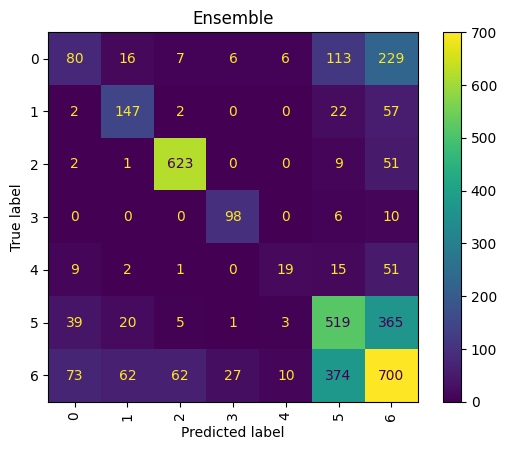

In [34]:
#print(roc_auc_score(y_test, stack_pred, multi_class = 'ovr'))
cm = confusion_matrix(y_test,clf_stack.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Ensemble")
plt.xticks(rotation=90)
plt.show();

# 6. Predictions

In [35]:
pred =  clf_stack.predict_proba(test.drop(columns=['id']))
predictions = pd.DataFrame(pred[:, 0:], columns=[target_col])
predictions['id'] = test['id']
predictions.to_csv('submission.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [36]:
predictions.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,id
0,0.722846,0.000050,0.000303,0.000009,0.003212,0.062348,0.245286,19219
1,0.149332,0.000861,0.000822,0.000013,0.151570,0.103719,0.398691,19220
2,0.020680,0.026701,0.027893,0.000006,0.000488,0.379348,0.526811,19221
3,0.171926,0.000165,0.000076,0.000007,0.004689,0.249637,0.429839,19222
4,0.013681,0.000075,0.000084,0.000018,0.000800,0.602626,0.271074,19223


# 7. Conclusions
As I mentioned in my Visual EDA notebook : https://www.kaggle.com/code/anopsy/visual-eda-steel-plate-defect-pred
there is some space for feature transformations, binning and feature engineering and/or selection. 
I also have to research why roc_auc_score worked for results from xgb and not for models.
I would also like to add weighted classes to my models and research the differences between ovo and ovr strategies

## If you have any comments or tips feel free to comment!